In [1]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import statsmodels.tsa.ar_model as ar
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np


file format: {model}.{date}.{cycle}.{metric}.csv
create program to compare the forecasted degree days to the observed degree days as well
as the forecast for two days ahead compared to what it is forecasting for the same day the next day

TIMESERIES ANALYSIS


In [2]:
path = "RawData"

In [3]:
files = glob.glob(path + '/ecmwf-eps.*.pw_cdd.csv')

In [4]:
sorted_files = sorted(files, key=lambda x: (x.split('.')[1], x.split('.')[2]))

### actual vs forecasted for the first forecasted day

In [26]:
errors_list = []
errors = {}
forecasts = {}
observed = {}
for i in range(0, len(sorted_files)-1):
    df1 = pd.read_csv(sorted_files[i])
    forecast = df1[df1.iloc[:, 2] == 1].iloc[0]['Value']
    forecast_date = df1[df1.iloc[:, 2] == 1].iloc[0]['Date']

    df2 = pd.read_csv(sorted_files[i+1])
    observation = df2[df2.iloc[:, 2] == 0].iloc[-1]['Value']
    observation_date = df2[df2.iloc[:, 2] == 0].iloc[-1]['Date']

    error = observation - forecast

    errors[forecast_date] = error
    forecasts[forecast_date] = forecast
    observed[observation_date] = observation
    errors_list.append(error)

In [27]:
mean_error = sum(errors.values())/len(errors.values())

In [28]:
mean_error

0.02206426155580602

In [29]:
errors = pd.DataFrame.from_dict(errors, orient='index')
forecasts = pd.DataFrame.from_dict(forecasts, orient='index')
observed = pd.DataFrame.from_dict(observed, orient='index')

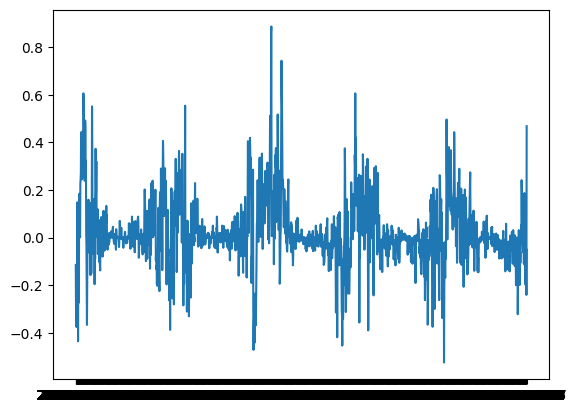

In [30]:
fig, ax = plt.subplots()
ax.plot(errors.index, errors[0], label='error')
plt.show()

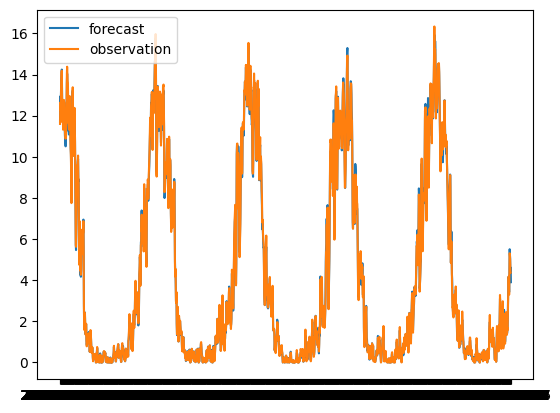

In [31]:
fig, ax = plt.subplots()
#ax.plot(errors.index, errors[0], label='error')
ax.plot(forecasts.index, forecasts[0], label='forecast')
ax.plot(observed.index, observed[0], label='observation')
ax.legend()
plt.show()

In [32]:
forecasts = forecasts.rename(columns={0: 'forecast'})
observed = observed.rename(columns={0: 'observation'})
errors = errors.rename(columns={0: 'error'})

In [33]:
master_df = pd.concat([forecasts, observed, errors], axis=1)

In [34]:
master_df

,forecast,observation,error
2018-07-09,11.712,11.597,-0.115
2018-07-10,12.936,12.628,-0.308
2018-07-11,12.566,12.273,-0.293
2018-07-12,12.706,12.330,-0.376
2018-07-13,13.287,13.026,-0.261
...,...,...,...
2023-05-13,5.253,5.225,-0.078
2023-05-14,5.049,4.958,-0.184
2023-05-15,4.360,4.431,-0.047
2023-05-16,4.613,4.372,-0.241


In [35]:
autocorr = errors['error'].autocorr()

In [36]:
autocorr

0.679373104086965

In [38]:
acf_values = acf(errors['error'])

In [39]:
acf_values

array([1.        , 0.6771645 , 0.47859713, 0.37852185, 0.33617929,
       0.3182566 , 0.28833356, 0.28175258, 0.25791183, 0.22001813,
       0.18541467, 0.17167347, 0.16875857, 0.15322513, 0.14050706,
       0.12762159, 0.0718814 , 0.07296296, 0.06871584, 0.07032714,
       0.05229483, 0.03273984, 0.03355185, 0.03674562, 0.05096182,
       0.07134207, 0.08244792, 0.08345082, 0.06484786, 0.04515393,
       0.04911297, 0.05323651, 0.0462466 ])

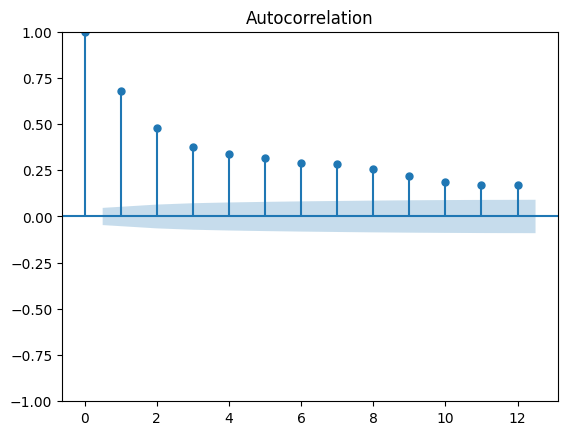

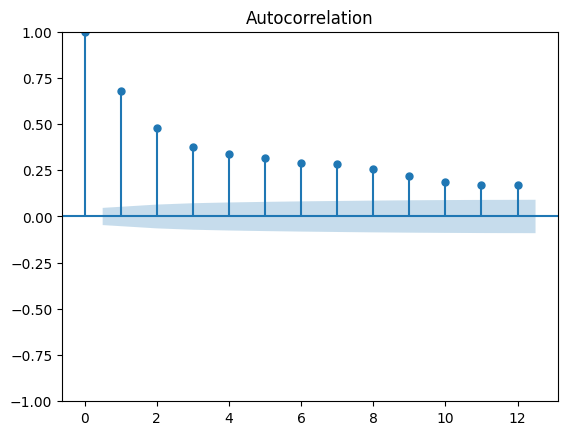

In [45]:
plot_acf(errors['error'], lags=12)

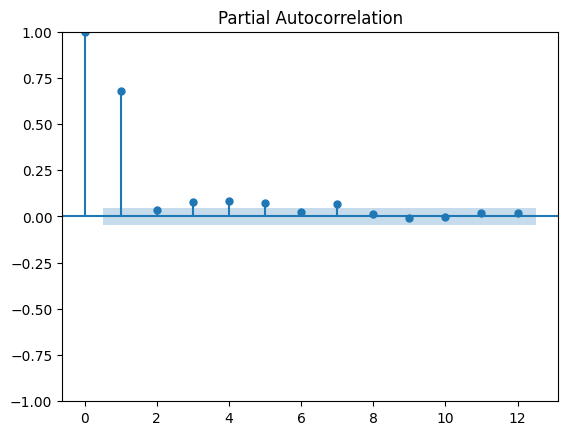

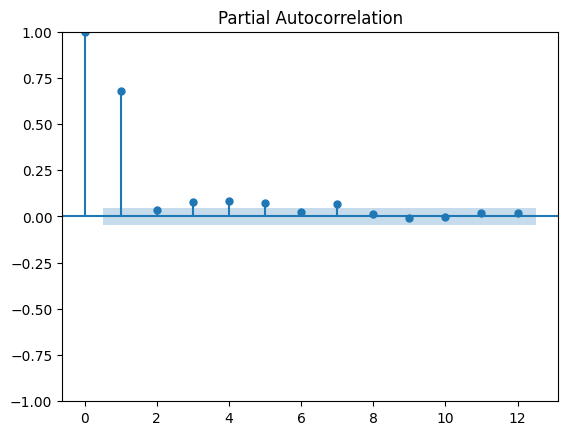

In [48]:
plot_pacf(errors['error'], lags=12)

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [93]:
decompose_result = seasonal_decompose(errors['error'], model="additive", period=365)

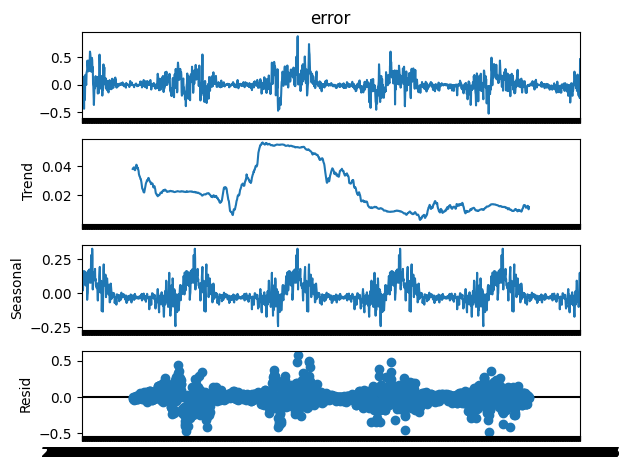

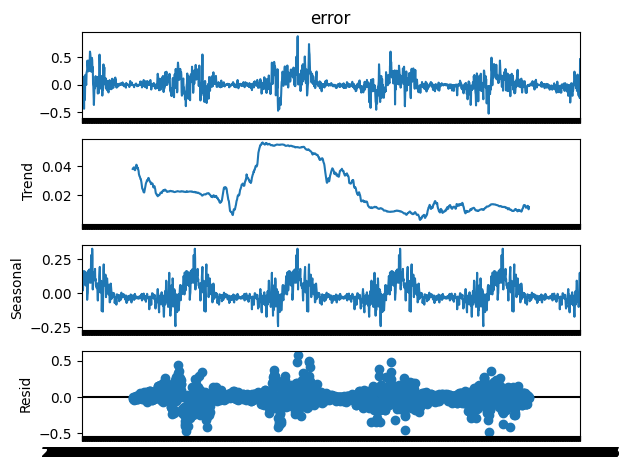

In [94]:
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot()

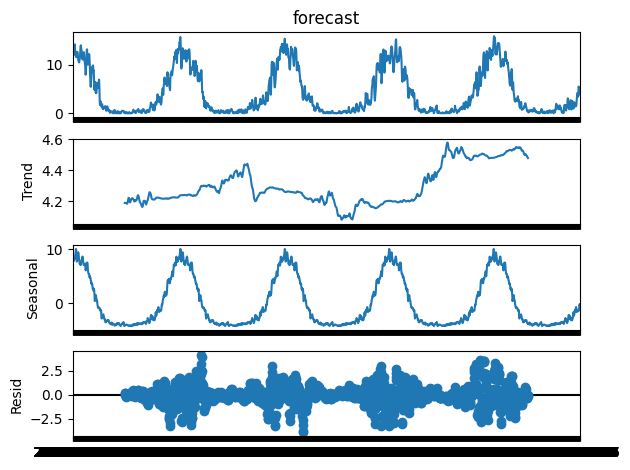

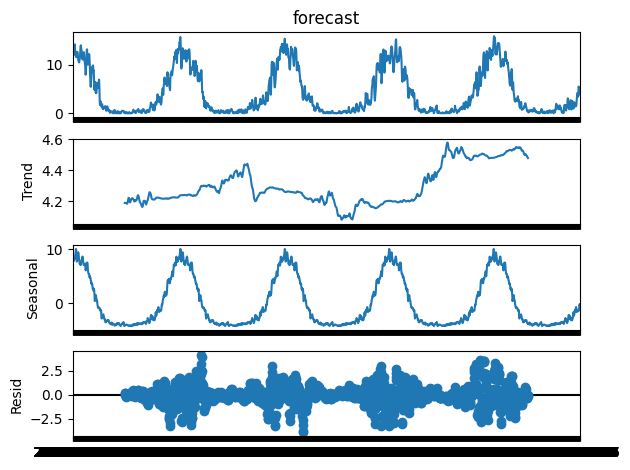

In [95]:
decompose_result = seasonal_decompose(forecasts['forecast'], model="additive", period=365)
trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot()

### autoregressive model

In [64]:
from statsmodels.tsa.ar_model import AutoReg

In [70]:
train_size = int(len(errors) * 0.70)
train, test = errors[0:train_size], errors[train_size:]

In [74]:
lags = 6
model = AutoReg(train, lags=lags)
model_fit = model.fit()

/Users/nickgault/opt/miniconda3/envs/untitled/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [75]:
n_steps = 5
forecast_values = model_fit.forecast(steps=n_steps)

print(forecast_values)

2021-12-01    0.003958
2021-12-02    0.011376
2021-12-03    0.015589
2021-12-04    0.018305
2021-12-05    0.019921
Freq: D, dtype: float64


/Users/nickgault/opt/miniconda3/envs/untitled/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


### ARIMA model

In [97]:
from statsmodels.tsa.arima.model import ARIMA

In [103]:
p, d, q = 2, 0, 1
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

/Users/nickgault/opt/miniconda3/envs/untitled/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/nickgault/opt/miniconda3/envs/untitled/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/nickgault/opt/miniconda3/envs/untitled/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/nickgault/opt/miniconda3/envs/untitled/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nic

                               SARIMAX Results                                
Dep. Variable:                  error   No. Observations:                 1241
Model:                 ARIMA(2, 0, 1)   Log Likelihood                1043.555
Date:                Thu, 18 May 2023   AIC                          -2077.109
Time:                        10:57:06   BIC                          -2051.491
Sample:                    07-09-2018   HQIC                         -2067.475
                         - 11-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0322      0.010      3.214      0.001       0.013       0.052
ar.L1         -0.2493      0.031     -7.916      0.000      -0.311      -0.188
ar.L2          0.6404      0.027     23.807      0.0

/Users/nickgault/opt/miniconda3/envs/untitled/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [105]:
forecast_values = model_fit.predict(start='2022-07-17', end='2022-07-22')
print(forecast_values)

2021-07-17    0.142144
2021-07-18    0.079552
2021-07-19    0.203548
2021-07-20    0.135360
2021-07-21    0.155236
2021-07-22    0.162466
Freq: D, Name: predicted_mean, dtype: float64


In [106]:
train

,error
2018-07-09,-0.115
2018-07-10,-0.308
2018-07-11,-0.293
2018-07-12,-0.376
2018-07-13,-0.261
...,...
2021-11-26,-0.020
2021-11-27,0.007
2021-11-28,-0.001
2021-11-29,0.003


### Timeseries Forecasting using Recurrent Neural Network

In [ ]:
#use tensorflow or keras to create a recurrent neural network to forecast the errors